In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Globals
ORANGE = '#F2BE4A'
RED = '#ef4123'
GRAY = '#545453'

### Prepare Data

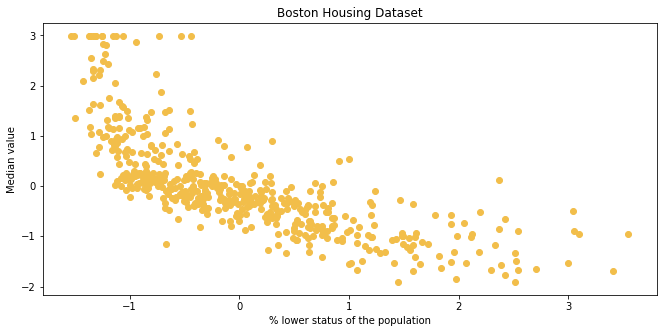

In [3]:
data = pd.read_csv('./data/boston_housing.csv')
scaler = StandardScaler()

data = data.dropna()

X = data['lstat'].values
X = X.reshape(-1, 1)
X = scaler.fit_transform(X)

y = data['medv'].values
y = y.reshape(-1, 1)
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

plt.figure(figsize=(11, 5))

plt.title("Boston Housing Dataset")
plt.xlabel('% lower status of the population')
plt.ylabel('Median value')

plt.scatter(x = X, y = y, color=ORANGE)
plt.show()

In [4]:
def print_evaluation_metrics(actual_values, predictions):
    print (f'MAE: {metrics.mean_absolute_error(actual_values, predictions)}')
    print (f'MSE: {metrics.mean_squared_error(actual_values, predictions)}')
    print(f'RMSE: {sqrt(metrics.mean_squared_error(actual_values, predictions))}')
    print (f'R Squared: {metrics.r2_score(actual_values, predictions)}')

## Momentum Optimizer

In [5]:
class MyMomentumOptimizer():
    def __init__(self, learning_rate, momentum = 0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.w = 0
        self.b = 0
        
        self.momentum_vector_w = 0 
        self.momentum_vector_b = 0
    
    def _get_batch(self, X, y, batch_size):
        indexes = np.random.randint(len(X), size=batch_size)
        return X[indexes,:], y[indexes,:]
    
    def _get_momentum_vector(self, X_batch, y_batch):
        f = y_batch - (self.w * X_batch + self.b)
        
        self.momentum_vector_w = self.momentum * self.momentum_vector_w + \
                                 self.learning_rate * (-2 * X_batch.dot(f.T).sum() / len(X_batch))
        self.momentum_vector_b = self.momentum * self.momentum_vector_b + \
                                 self.learning_rate * (-2 * f.sum() / len(X_batch))
    
    def fit(self, X, y, batch_size = 32, epochs = 100):
        history = []
        
        for e in range(epochs):
            
            indexes = np.random.randint(len(X), size=batch_size)
            X_batch, y_batch = self._get_batch(X, y, batch_size)
            
            self._get_momentum_vector(X_batch, y_batch)
            
            self.w -= self.momentum_vector_w
            self.b -= self.momentum_vector_b
        
            loss = metrics.mean_squared_error(y_batch, (self.w * X_batch + self.b))
                                      
            if e % 100 == 0:
                print(f"Epoch: {e}, Loss: {loss})")
            
            history.append(loss)

        return history
                
    def predict(self, X):
        return self.w * X + self.b

In [6]:
model = MyMomentumOptimizer(learning_rate = 0.0001)
history = model.fit(X_train, y_train, batch_size = 128, epochs = 1000)

predictions = model.predict(X_test)

Epoch: 0, Loss: 1.013641306716826)
Epoch: 100, Loss: 1.0162729184015082)
Epoch: 200, Loss: 0.7180058729532355)
Epoch: 300, Loss: 0.8115584340807549)
Epoch: 400, Loss: 0.4798075637343214)
Epoch: 500, Loss: 0.5244198039251231)
Epoch: 600, Loss: 0.6118332109391473)
Epoch: 700, Loss: 0.44029825791164184)
Epoch: 800, Loss: 0.5786896427247654)
Epoch: 900, Loss: 0.5411350037622117)


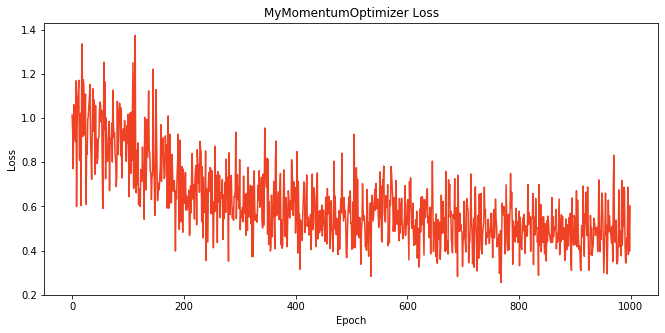

In [7]:
plt.figure(figsize=(11, 5))

plt.title("MyMomentumOptimizer Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(history, color=RED)

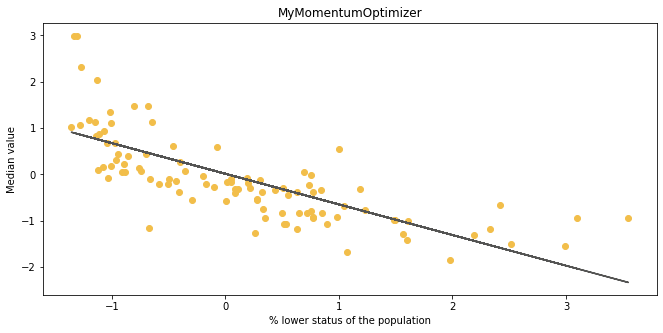

In [8]:
plt.figure(figsize=(11, 5))

plt.title("MyMomentumOptimizer")
plt.xlabel('% lower status of the population')
plt.ylabel('Median value')

plt.scatter(x = X_test, y = y_test, color=ORANGE)
values = np.column_stack((X_test, predictions))
plt.plot(values[:, 0], values[:, 1], color=GRAY)

plt.show()

In [9]:
print_evaluation_metrics(y_test, predictions)

MAE: 0.45749020206744284
MSE: 0.3797655050781035
RMSE: 0.616251170447654
R Squared: 0.552455178837516


In [10]:
pd.DataFrame({
    'Actual Value': y_test.flatten(),
    'MyMomentumOptimizer Prediction': predictions.flatten(),
})

,Actual Value,MyMomentumOptimizer Prediction
0,-0.221246,-0.475232
1,-1.842924,-1.294282
2,-0.993992,-0.971850
3,-1.081062,-0.337180
4,-0.145059,0.301198
...,...,...
97,0.268523,0.277108
98,-0.330083,-0.542868
99,-0.286548,-0.323282
100,-0.776317,-0.801370


## Nesterov Accelerated Gradient


In [11]:
class MyNestrovAcceleratedGradient():
    def __init__(self, learning_rate, momentum = 0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.w = 0
        self.b = 0
        
        self.momentum_vector_w = 0 
        self.momentum_vector_b = 0
    
    def _get_batch(self, X, y, batch_size):
        indexes = np.random.randint(len(X), size=batch_size)
        return X[indexes,:], y[indexes,:]
    
    def _get_momentum_vector(self, X_batch, y_batch):
        f = y_batch - ((self.w + self.momentum * self.momentum_vector_w) * X_batch + (self.momentum * self.momentum_vector_b))
        
        self.momentum_vector_w = self.momentum * self.momentum_vector_w + \
                                 self.learning_rate * (-2 * X_batch.dot(f.T).sum() / len(X_batch))
        
        self.momentum_vector_b = self.momentum * self.momentum_vector_b + \
                                 self.learning_rate * (-2 * f.sum() / len(X_batch))
    
    def fit(self, X, y, batch_size = 32, epochs = 100):
        history = []
        momentum_vector = np.zeros_like(1)
        
        for e in range(epochs):
            
            indexes = np.random.randint(len(X), size=batch_size)
            X_batch, y_batch = self._get_batch(X, y, batch_size)
            
            self._get_momentum_vector(X_batch, y_batch)
            
            self.w -= self.momentum_vector_w
            self.b -= self.momentum_vector_b
        
            loss = metrics.mean_squared_error(y_batch, (self.w * X_batch + self.b))
                                      
            if e % 100 == 0:
                print(f"Epoch: {e}, Loss: {loss})")
            
            history.append(loss)

        return history
                
    def predict(self, X):
        return self.w * X + self.b

In [12]:
model = MyNestrovAcceleratedGradient(learning_rate = 0.0001)
history = model.fit(X_train, y_train, batch_size = 128, epochs = 1000)

predictions = model.predict(X_test)

Epoch: 0, Loss: 0.7066860984843821)
Epoch: 100, Loss: 0.5914714196556561)
Epoch: 200, Loss: 0.8172490039134093)
Epoch: 300, Loss: 0.8562328765790095)
Epoch: 400, Loss: 0.3573104190215053)
Epoch: 500, Loss: 0.689382890706508)
Epoch: 600, Loss: 0.32927063130118495)
Epoch: 700, Loss: 0.5596258108001939)
Epoch: 800, Loss: 0.5155483334861969)
Epoch: 900, Loss: 0.523446209788953)


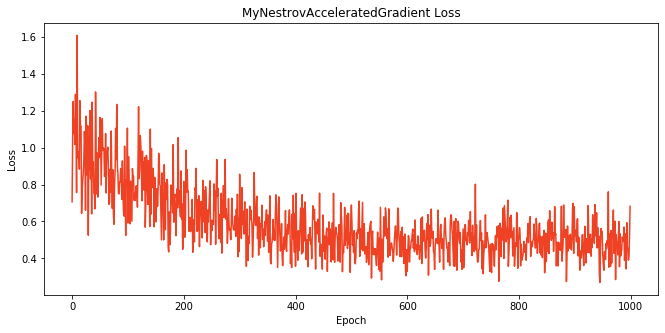

In [13]:
plt.figure(figsize=(11, 5))

plt.title("MyNestrovAcceleratedGradient Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(history, color=RED)

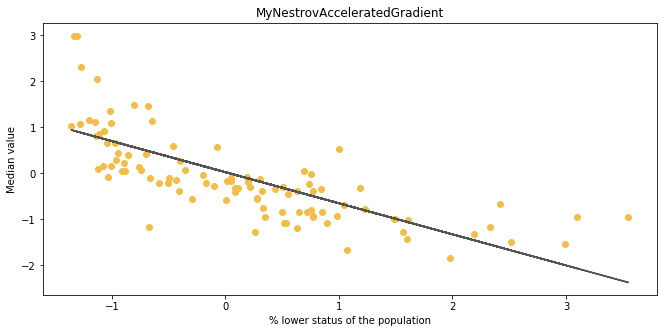

In [14]:
plt.figure(figsize=(11, 5))

plt.title("MyNestrovAcceleratedGradient")
plt.xlabel('% lower status of the population')
plt.ylabel('Median value')

plt.scatter(x = X_test, y = y_test, color=ORANGE)
values = np.column_stack((X_test, predictions))
plt.plot(values[:, 0], values[:, 1], color=GRAY)

plt.show()

In [15]:
print_evaluation_metrics(y_test, predictions)

MAE: 0.4619394570071683
MSE: 0.3822786132012503
RMSE: 0.618286837318449
R Squared: 0.5494935393244582


In [16]:
pd.DataFrame({
    'Actual Value': y_test.flatten(),
    'MyNestrovAcceleratedGradient Prediction': predictions.flatten(),
})

,Actual Value,MyNestrovAcceleratedGradient Prediction
0,-0.221246,-0.471823
1,-1.842924,-1.308543
2,-0.993992,-0.979155
3,-1.081062,-0.330793
4,-0.145059,0.321356
...,...,...
97,0.268523,0.296747
98,-0.330083,-0.540919
99,-0.286548,-0.316595
100,-0.776317,-0.804997


## AdaGrad

In [17]:
class MyAdaGrad():
    def __init__(self, learning_rate, epsilon = 10 ** -10):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
        self.w = 0
        self.b = 0
        
        self.scale_w = 0
        self.scale_b = 0
    
    def _get_batch(self, X, y, batch_size):
        indexes = np.random.randint(len(X), size=batch_size)
        return X[indexes,:], y[indexes,:]
    
    def _get_scale(self, X_batch, y_batch):
        f = y_batch - (self.w * X_batch + self.b)
        
        gradient_w = (-2 * X_batch.dot(f.T).sum() / len(X_batch))
        gradient_b = (-2 * f.sum() / len(X_batch))
        
        self.scale_w += np.multiply(gradient_w, gradient_w)
        self.scale_b += np.multiply(gradient_b, gradient_b)
    
    def fit(self, X, y, batch_size = 32, epochs = 100):
        history = []
        momentum_vector = np.zeros_like(1)
        
        for e in range(epochs):
            
            indexes = np.random.randint(len(X), size=batch_size)
            X_batch, y_batch = self._get_batch(X, y, batch_size)
            
            self._get_scale(X_batch, y_batch)
            
            f = y_batch - (self.w * X_batch + self.b)
            
            divider_w = np.sqrt(self.scale_w + self.epsilon) 
            divider_b = np.sqrt(self.scale_b + self.epsilon)
            
            gradient_w = (-2 * X_batch.dot(f.T).sum() / len(X_batch))
            gradient_b = (-2 * f.sum() / len(X_batch))
            
            self.w -= self.learning_rate * gradient_w / divider_w
            self.b -= self.learning_rate * gradient_b / divider_b
        
            loss = metrics.mean_squared_error(y_batch, (self.w * X_batch + self.b))
                                      
            if e % 100 == 0:
                print(f"Epoch: {e}, Loss: {loss})")
            
            history.append(loss)

        return history
                
    def predict(self, X):
        return self.w * X + self.b

In [18]:
model = MyAdaGrad(learning_rate = 0.1)
history = model.fit(X_train, y_train, batch_size = 128, epochs = 1000)

predictions = model.predict(X_test)

Epoch: 0, Loss: 0.930820539296557)
Epoch: 100, Loss: 0.528657589049589)
Epoch: 200, Loss: 0.4150965015147744)
Epoch: 300, Loss: 0.6046705841241111)
Epoch: 400, Loss: 0.4845316249661884)
Epoch: 500, Loss: 0.3233007461530447)
Epoch: 600, Loss: 0.5281053073388673)
Epoch: 700, Loss: 0.5614739701864354)
Epoch: 800, Loss: 0.3021182132335077)
Epoch: 900, Loss: 0.47660451920121333)


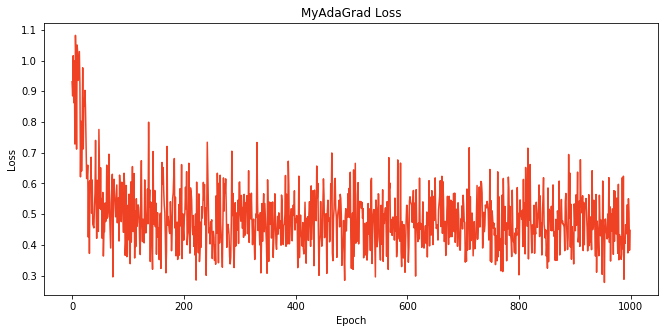

In [19]:
plt.figure(figsize=(11, 5))

plt.title("MyAdaGrad Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(history, color=RED)

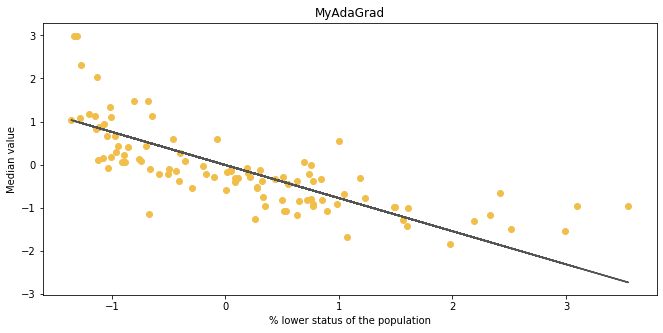

In [20]:
plt.figure(figsize=(11, 5))

plt.title("MyAdaGrad")
plt.xlabel('% lower status of the population')
plt.ylabel('Median value')

plt.scatter(x = X_test, y = y_test, color=ORANGE)
values = np.column_stack((X_test, predictions))
plt.plot(values[:, 0], values[:, 1], color=GRAY)

plt.show()

In [21]:
print_evaluation_metrics(y_test, predictions)

MAE: 0.4699765184026941
MSE: 0.3984129480183016
RMSE: 0.6311996102805368
R Squared: 0.5304796007394152


In [22]:
pd.DataFrame({
    'Actual Value': y_test.flatten(),
    'MyAdaGrad Prediction': predictions.flatten(),
})

,Actual Value,MyAdaGrad Prediction
0,-0.221246,-0.577028
1,-1.842924,-1.528828
2,-0.993992,-1.154138
3,-1.081062,-0.416600
4,-0.145059,0.325244
...,...,...
97,0.268523,0.297250
98,-0.330083,-0.655627
99,-0.286548,-0.400450
100,-0.776317,-0.956026


## RMSProp

In [23]:
class MyRMSProp():
    def __init__(self, learning_rate, decay_rate = 0.9, epsilon = 10 ** -10):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        
        self.w = 0
        self.b = 0
        
        self.scale_w = 0
        self.scale_b = 0
    
    def _get_batch(self, X, y, batch_size):
        indexes = np.random.randint(len(X), size=batch_size)
        return X[indexes,:], y[indexes,:]
    
    def _get_scale(self, X_batch, y_batch):
        f = y_batch - (self.w * X_batch + self.b)
        
        gradient_w = (-2 * X_batch.dot(f.T).sum() / len(X_batch))
        gradient_b = (-2 * f.sum() / len(X_batch))
        
        self.scale_w = self.decay_rate * self.scale_w + (1 - self.decay_rate) * np.multiply(gradient_w, gradient_w)
        self.scale_b = self.decay_rate * self.scale_b + (1 - self.decay_rate) * np.multiply(gradient_b, gradient_b)
    
    def fit(self, X, y, batch_size = 32, epochs = 100):
        history = []
        momentum_vector = np.zeros_like(1)
        
        for e in range(epochs):
            
            indexes = np.random.randint(len(X), size=batch_size)
            X_batch, y_batch = self._get_batch(X, y, batch_size)
            
            self._get_scale(X_batch, y_batch)
            
            f = y_batch - (self.w * X_batch + self.b)
            
            divider_w = np.sqrt(self.scale_w + self.epsilon) 
            divider_b = np.sqrt(self.scale_b + self.epsilon)
            
            gradient_w = (-2 * X_batch.dot(f.T).sum() / len(X_batch))
            gradient_b = (-2 * f.sum() / len(X_batch))
            
            self.w -= self.learning_rate * gradient_w / divider_w
            self.b -= self.learning_rate * gradient_b / divider_b
        
            loss = metrics.mean_squared_error(y_batch, (self.w * X_batch + self.b))
                                      
            if e % 100 == 0:
                print(f"Epoch: {e}, Loss: {loss})")
            
            history.append(loss)

        return history
                
    def predict(self, X):
        return self.w * X + self.b

In [24]:
model = MyRMSProp(learning_rate = 0.01)
history = model.fit(X_train, y_train, batch_size = 128, epochs = 2000)

predictions = model.predict(X_test)

Epoch: 0, Loss: 1.1196442130459818)
Epoch: 100, Loss: 0.5649869661370592)
Epoch: 200, Loss: 0.5093850491824736)
Epoch: 300, Loss: 0.5180049347254246)
Epoch: 400, Loss: 0.4848912879901342)
Epoch: 500, Loss: 0.4789025710447181)
Epoch: 600, Loss: 0.4903202971179614)
Epoch: 700, Loss: 0.5967313131049943)
Epoch: 800, Loss: 0.4690268485236033)
Epoch: 900, Loss: 0.43956590015388514)
Epoch: 1000, Loss: 0.5969611769163328)
Epoch: 1100, Loss: 0.395999599047108)
Epoch: 1200, Loss: 0.28280726440238085)
Epoch: 1300, Loss: 0.44363534332345944)
Epoch: 1400, Loss: 0.5346696226282079)
Epoch: 1500, Loss: 0.5476500943913529)
Epoch: 1600, Loss: 0.5659860063288691)
Epoch: 1700, Loss: 0.5843556935109948)
Epoch: 1800, Loss: 0.42828689930965574)
Epoch: 1900, Loss: 0.42528911965948424)


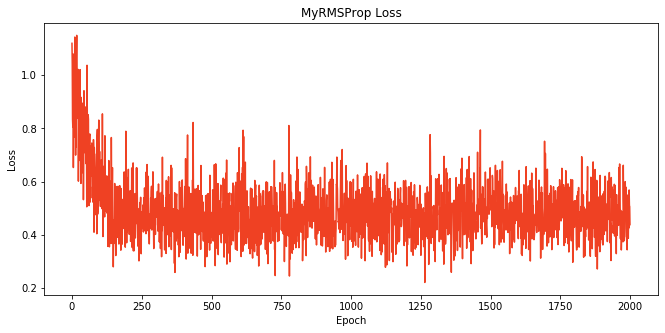

In [25]:
plt.figure(figsize=(11, 5))

plt.title("MyRMSProp Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(history, color=RED)

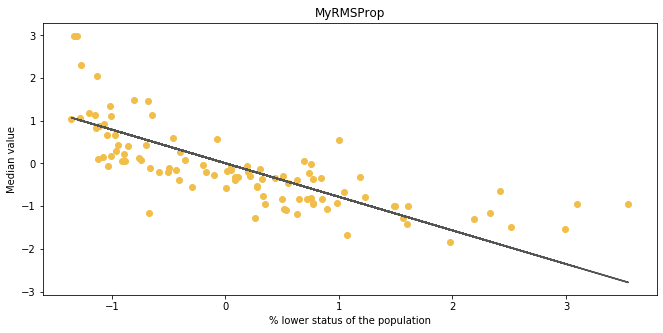

In [26]:
plt.figure(figsize=(11, 5))

plt.title("MyRMSProp")
plt.xlabel('% lower status of the population')
plt.ylabel('Median value')

plt.scatter(x = X_test, y = y_test, color=ORANGE)
values = np.column_stack((X_test, predictions))
plt.plot(values[:, 0], values[:, 1], color=GRAY)

plt.show()

In [27]:
print_evaluation_metrics(y_test, predictions)

MAE: 0.4774646823884669
MSE: 0.40524280663032064
RMSE: 0.6365868413895472
R Squared: 0.5224307711058431


In [28]:
pd.DataFrame({
    'Actual Value': y_test.flatten(),
    'MyRMSProp Prediction': predictions.flatten(),
})

,Actual Value,MyRMSProp Prediction
0,-0.221246,-0.576645
1,-1.842924,-1.551702
2,-0.993992,-1.167856
3,-1.081062,-0.412297
4,-0.145059,0.347674
...,...,...
97,0.268523,0.318996
98,-0.330083,-0.657164
99,-0.286548,-0.395752
100,-0.776317,-0.964903


## Adam

In [29]:
class MyAdam():
    def __init__(self, learning_rate, momentum_decay = 0.9, scaling_decay = 0.95, epsilon = 10 ** -8):
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.momentum_decay = momentum_decay
        self.scaling_decay = scaling_decay
        self.w = 0
        self.b = 0
        self.scale_w = 0
        self.scale_b = 0
        self.momentum_vector_w = 0 
        self.momentum_vector_b = 0
    
    def _get_batch(self, X, y, batch_size):
        indexes = np.random.randint(len(X), size=batch_size)
        return X[indexes,:], y[indexes,:]
    
    def _get_gradients(self, X_batch, y_batch):
        f = y_batch - (self.w * X_batch + self.b)
        
        gradient_w = (-2 * X_batch.dot(f.T).sum() / len(X_batch))
        gradient_b = (-2 * f.sum() / len(X_batch))
        
        return gradient_w, gradient_b
    
    def _get_momentum_vector(self, X_batch, y_batch, gradient_w, gradient_b, epoch):
        self.momentum_vector_w = self.momentum_decay * self.momentum_vector_w + (1 - self.momentum_decay) * gradient_w
        self.momentum_vector_b = self.momentum_decay * self.momentum_vector_b + (1 - self.momentum_decay) * gradient_b
        
        self.momentum_vector_w = self.momentum_vector_w / (1 - self.momentum_decay**epoch)
        self.momentum_vector_b = self.momentum_vector_b / (1 - self.momentum_decay**epoch)
    
    def _get_scale(self, X_batch, y_batch, gradient_w, gradient_b, epoch):
        self.scale_w = self.scaling_decay * self.scale_w + (1 - self.scaling_decay) * np.multiply(gradient_w, gradient_w)
        self.scale_b = self.scaling_decay * self.scale_b + (1 - self.scaling_decay) * np.multiply(gradient_b, gradient_b)
        
        self.scale_w = self.scale_w / (1 - self.scaling_decay**epoch)
        self.scale_b = self.scale_b / (1 - self.scaling_decay**epoch)
        
    def fit(self, X, y, batch_size = 32, epochs = 100):
        history = []
        momentum_vector = np.zeros_like(1)
        
        for e in range(epochs):
            
            indexes = np.random.randint(len(X), size=batch_size)
            X_batch, y_batch = self._get_batch(X, y, batch_size)
            
            gradient_w, gradient_b = self._get_gradients(X_batch, y_batch)

            self._get_scale(X_batch, y_batch, gradient_w, gradient_b, e + 1)
            self._get_momentum_vector(X_batch, y_batch,gradient_w, gradient_b, e + 1)
            
            divider_w = np.sqrt(self.scale_w + self.epsilon) 
            divider_b = np.sqrt(self.scale_b + self.epsilon)
            
            self.w -= self.learning_rate * self.momentum_vector_w * gradient_w / divider_w
            self.b -= self.learning_rate * self.momentum_vector_b * gradient_b / divider_b
            
            loss = metrics.mean_squared_error(y_batch, (self.w * X_batch + self.b))
                                      
            if e % 100 == 0:
                print(f"Epoch: {e}, Loss: {loss})")
            
            history.append(loss)

        return history
                
    def predict(self, X):
        return self.w * X + self.b

In [30]:
model = MyAdam(learning_rate = 0.001)
history = model.fit(X_train, y_train, batch_size = 32, epochs = 2000)

predictions = model.predict(X_test)

Epoch: 0, Loss: 1.131479334122679)
Epoch: 100, Loss: 1.4400755078832117)
Epoch: 200, Loss: 1.037433601657908)
Epoch: 300, Loss: 1.0649951537360238)
Epoch: 400, Loss: 1.2959681864165074)
Epoch: 500, Loss: 1.2250747052652056)
Epoch: 600, Loss: 0.7370345001249112)
Epoch: 700, Loss: 0.8359520752282336)
Epoch: 800, Loss: 0.8409571629275158)
Epoch: 900, Loss: 0.2147120776099104)
Epoch: 1000, Loss: 0.14930681186589007)
Epoch: 1100, Loss: 0.3706352533215188)
Epoch: 1200, Loss: 0.843987544296986)
Epoch: 1300, Loss: 0.3697676570170162)
Epoch: 1400, Loss: 0.6316553742570216)
Epoch: 1500, Loss: 0.3473493419952677)
Epoch: 1600, Loss: 0.5404263456497658)
Epoch: 1700, Loss: 0.5684936434677657)
Epoch: 1800, Loss: 0.4275170576315157)
Epoch: 1900, Loss: 0.7919449565192604)


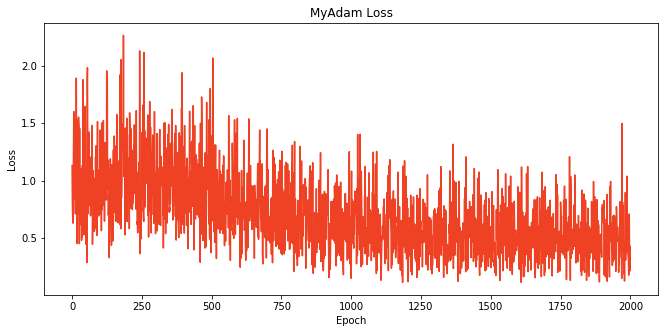

In [31]:
plt.figure(figsize=(11, 5))

plt.title("MyAdam Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(history, color=RED)

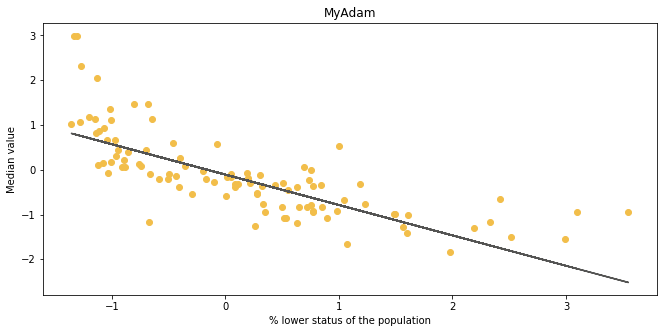

In [32]:
plt.figure(figsize=(11, 5))

plt.title("MyAdam")
plt.xlabel('% lower status of the population')
plt.ylabel('Median value')

plt.scatter(x = X_test, y = y_test, color=ORANGE)
values = np.column_stack((X_test, predictions))
plt.plot(values[:, 0], values[:, 1], color=GRAY)

plt.show()

In [33]:
print_evaluation_metrics(y_test, predictions)

MAE: 0.4462751700202244
MSE: 0.38480374716606863
RMSE: 0.6203255171005532
R Squared: 0.546517727636497


In [34]:
pd.DataFrame({
    'Actual Value': y_test.flatten(),
    'MyAdam Prediction': predictions.flatten(),
})

,Actual Value,MyAdam Prediction
0,-0.221246,-0.610648
1,-1.842924,-1.451497
2,-0.993992,-1.120484
3,-1.081062,-0.468921
4,-0.145059,0.186446
...,...,...
97,0.268523,0.161715
98,-0.330083,-0.680085
99,-0.286548,-0.454653
100,-0.776317,-0.945466
